## Importing the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
model_df = pd.read_csv('Data_inc_EDA.csv')

In [3]:
model_df.shape

(28970, 13)

In [4]:
model_df.head()

,Age,Profession Class,Education-num,marital-status,occupation,relationship,race,Gender,capital-gain,capital-loss,hours-per-week,country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Preprocessing for Model Building

### Outliers Detection for Numeric Columns

In [5]:
numeric_cols = list(model_df.describe().columns)
numeric_cols.remove('Education-num')  # Removing Education-num which is actually categorical

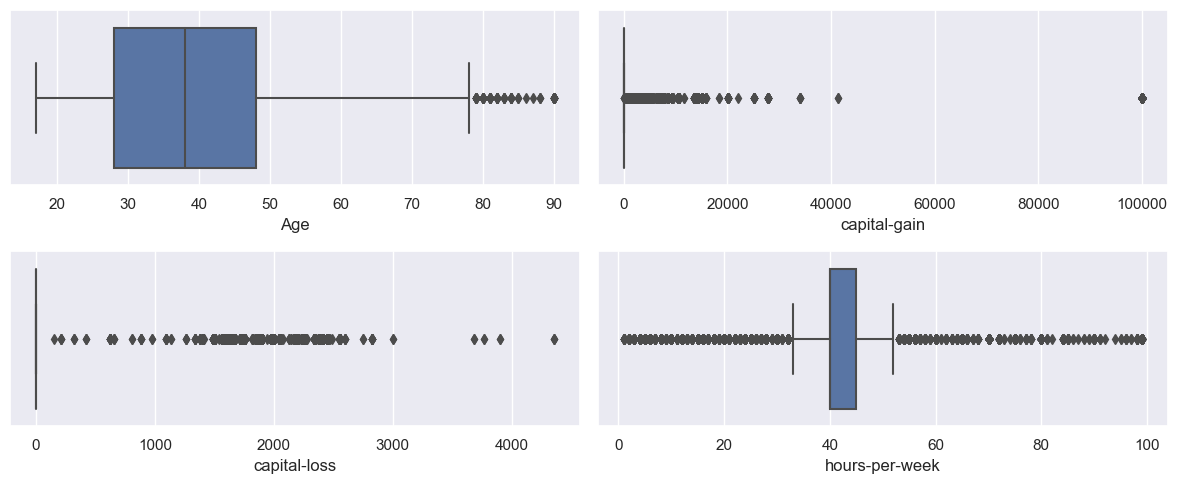

In [6]:
plt.figure(figsize = (12, 5))
x = 1

for column in numeric_cols:
    plt.subplot(2, 2, x)
    sns.boxplot(model_df[column])
    x += 1

plt.tight_layout()

###### Columns Age and hrs-per-week don't have outliers but column capital-gain needs to be treated. We will ignore capital-loss for now.

In [7]:
model_df['capital-gain'] = np.where(model_df['capital-gain'] > 45000, model_df['capital-gain'].median(),
                                    model_df['capital-gain'])

<AxesSubplot:xlabel='capital-gain'>

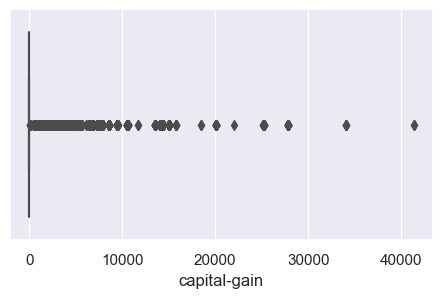

In [8]:
plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
sns.boxplot(model_df['capital-gain'])

### Skewness Treatment

In [9]:
model_df.skew()

Age               0.540350
Education-num    -0.351827
capital-gain      5.527556
capital-loss      4.310924
hours-per-week    0.240220
dtype: float64

###### Education-num can be ignored as it is categorical. But the skewness of capital-gain and capital-loss columns can be reduced by using cube root transformations twice.

In [10]:
model_df['capital-gain'] = np.cbrt(model_df['capital-gain'])
model_df['capital-gain'] = np.cbrt(model_df['capital-gain'])
model_df['capital-loss'] = np.cbrt(model_df['capital-loss'])
model_df['capital-loss'] = np.cbrt(model_df['capital-loss'])

In [11]:
model_df.skew()

Age               0.540350
Education-num    -0.351827
capital-gain      2.957143
capital-loss      4.033542
hours-per-week    0.240220
dtype: float64

In [12]:
model_df.duplicated().sum()

25

In [13]:
model_df.drop_duplicates(inplace = True)  # Duplicate rows dropped

### Encoding the Data

In [14]:
model_df.describe(include = ['O']).columns

Index(['Profession Class', 'marital-status', 'occupation', 'relationship',
       'race', 'Gender', 'country', 'income'],
      dtype='object')

In [15]:
label_enc = LabelEncoder()

In [16]:
model_df['income'] = label_enc.fit_transform(model_df['income'])

In [17]:
model_df['income'].value_counts()

0    21790
1     7155
Name: income, dtype: int64

###### In our target column, <=50K has been labelled as 0 and >50K as 1.

In [18]:
model_df = pd.get_dummies(model_df, columns = ['Profession Class', 'marital-status', 'occupation', 'relationship', 'race',
                                              'Gender', 'country'], drop_first = True)

In [19]:
model_df.head()

,Age,Education-num,capital-gain,capital-loss,hours-per-week,income,Profession Class_Local-gov,Profession Class_Never-worked,Profession Class_Private,Profession Class_Self-emp-inc,Profession Class_Self-emp-not-inc,Profession Class_State-gov,Profession Class_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Not-working,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,Gender_Male,country_Canada,country_China,country_Columbia,country_Cuba,country_Dominican-Republic,country_Ecuador,country_El-Salvador,country_England,country_France,country_Germany,country_Greece,country_Guatemala,country_Haiti,country_Holand-Netherlands,country_Honduras,country_Hong,country_Hungary,country_India,country_Iran,country_Ireland,country_Italy,country_Jamaica,country_Japan,country_Laos,country_Mexico,country_Nicaragua,country_Outlying-US(Guam-USVI-etc),country_Peru,country_Philippines,country_Poland,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Vietnam,country_Yugoslavia
0,39,13,2.348587,0.0,40,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,13,0.000000,0.0,13,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,9,0.000000,0.0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,7,0.000000,0.0,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,13,0.000000,0.0,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Dropping the column occupation_Not-working because it conveys the same information as column Profession Class_Without-pay
model_df.drop('occupation_Not-working', axis = 1, inplace = True)

In [21]:
model_df.shape

(28945, 82)

### Scaling the Data

In [22]:
# Separating features and target before scaling
features = model_df.drop('income', axis = 1)
features.shape

(28945, 81)

In [23]:
target = model_df['income']
target.shape

(28945,)

In [24]:
scale = StandardScaler()

In [25]:
features_scaled = scale.fit_transform(features)
features_scaled

array([[-0.02015123,  1.09599476,  2.84164525, ...,  0.32693021,
        -0.04816747, -0.02351762],
       [ 0.78366384,  1.09599476, -0.30892008, ...,  0.32693021,
        -0.04816747, -0.02351762],
       [-0.09322533, -0.41510108, -0.30892008, ...,  0.32693021,
        -0.04816747, -0.02351762],
       ...,
       [-0.89704041,  0.7182208 , -0.30892008, ...,  0.32693021,
        -0.04816747, -0.02351762],
       [ 1.36825663, -0.41510108, -0.30892008, ...,  0.32693021,
        -0.04816747, -0.02351762],
       [ 0.92981204, -0.41510108,  3.59651264, ...,  0.32693021,
        -0.04816747, -0.02351762]])

In [26]:
features_df = pd.DataFrame(features_scaled, columns = features.columns)
features_df.head()

,Age,Education-num,capital-gain,capital-loss,hours-per-week,Profession Class_Local-gov,Profession Class_Never-worked,Profession Class_Private,Profession Class_Self-emp-inc,Profession Class_Self-emp-not-inc,Profession Class_State-gov,Profession Class_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,Gender_Male,country_Canada,country_China,country_Columbia,country_Cuba,country_Dominican-Republic,country_Ecuador,country_El-Salvador,country_England,country_France,country_Germany,country_Greece,country_Guatemala,country_Haiti,country_Holand-Netherlands,country_Honduras,country_Hong,country_Hungary,country_India,country_Iran,country_Ireland,country_Italy,country_Jamaica,country_Japan,country_Laos,country_Mexico,country_Nicaragua,country_Outlying-US(Guam-USVI-etc),country_Peru,country_Philippines,country_Poland,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Vietnam,country_Yugoslavia
0,-0.020151,1.095995,2.841645,-0.234595,-0.050606,-0.275213,-0.015553,-1.641439,-0.197627,-0.305511,4.666198,-0.021998,-0.0282,-0.913455,-0.121049,1.475560,-0.190535,-0.187398,-0.017636,-0.357738,-0.382896,-0.185413,-0.205607,-0.249793,-0.339157,-0.071446,-0.480810,-0.149284,-0.3562,-0.176452,-0.229144,1.666358,-0.185612,-0.403456,-0.359578,-0.235913,-0.19286,-0.342063,-0.097217,0.437602,0.716509,-0.064791,-0.050969,-0.045194,-0.057384,-0.049237,-0.031117,-0.060627,-0.055848,-0.031669,-0.068961,-0.031669,-0.046331,-0.039018,-0.005878,-0.021197,-0.026295,-0.021197,-0.05888,-0.038572,-0.0282,-0.050283,-0.052974,-0.046331,-0.024945,-0.149526,-0.034293,-0.021998,-0.032744,-0.082992,-0.045576,-0.035776,-0.062881,-0.020365,-0.052645,-0.042013,-0.024945,-0.025629,0.326930,-0.048167,-0.023518
1,0.783664,1.095995,-0.308920,-0.234595,-2.168361,-0.275213,-0.015553,-1.641439,-0.197627,3.273207,-0.214307,-0.021998,-0.0282,1.094745,-0.121049,-0.677709,-0.190535,-0.187398,-0.017636,-0.357738,2.611677,-0.185413,-0.205607,-0.249793,-0.339157,-0.071446,-0.480810,-0.149284,-0.3562,-0.176452,-0.229144,-0.600111,-0.185612,-0.403456,-0.359578,-0.235913,-0.19286,-0.342063,-0.097217,0.437602,0.716509,-0.064791,-0.050969,-0.045194,-0.057384,-0.049237,-0.031117,-0.060627,-0.055848,-0.031669,-0.068961,-0.031669,-0.046331,-0.039018,-0.005878,-0.021197,-0.026295,-0.021197,-0.05888,-0.038572,-0.0282,-0.050283,-0.052974,-0.046331,-0.024945,-0.149526,-0.034293,-0.021998,-0.032744,-0.082992,-0.045576,-0.035776,-0.062881,-0.020365,-0.052645,-0.042013,-0.024945,-0.025629,0.326930,-0.048167,-0.023518
2,-0.093225,-0.415101,-0.308920,-0.234595,-0.050606,-0.275213,-0.015553,0.609222,-0.197627,-0.305511,-0.214307,-0.021998,-0.0282,-0.913455,-0.121049,-0.677709,-0.190535,-0.187398,-0.017636,-0.357738,-0.382896,-0.185413,4.863643,-0.249793,-0.339157,-0.071446,-0.480810,-0.149284,-0.3562,-0.176452,-0.229144,1.666358,-0.185612,-0.403456,-0.359578,-0.235913,-0.19286,-0.342063,-0.097217,0.437602,0.716509,-0.064791,-0.050969,-0.045194,-0.057384,-0.049237,-0.031117,-0.060627,-0.055848,-0.031669,-0.068961,-0.031669,-0.046331,-0.039018,-0.005878,-0.021197,-0.026295,-0.021197,-0.05888,-0.038572,-0.0282,-0.050283,-0.052974,-0.046331,-0.024945,-0.149526,-0.034293,-0.021998,-0.032744,-0.082992,-0.045576,-0.035776,-0.062881,-0.020365,-0.052645,-0.042013,-0.02494

### Feature Selection

In [27]:
# Creating a train-test split of 70% data in training set and 30% data in testing set
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size = 0.3, random_state = 42)

In [28]:
# Creating instance of ExtraTreesClassifier for feature selection
extractor = ExtraTreesClassifier(random_state = 42)
extractor.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

In [29]:
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': extractor.feature_importances_})
feature_rank.sort_values('importance', ascending = False, inplace = True)

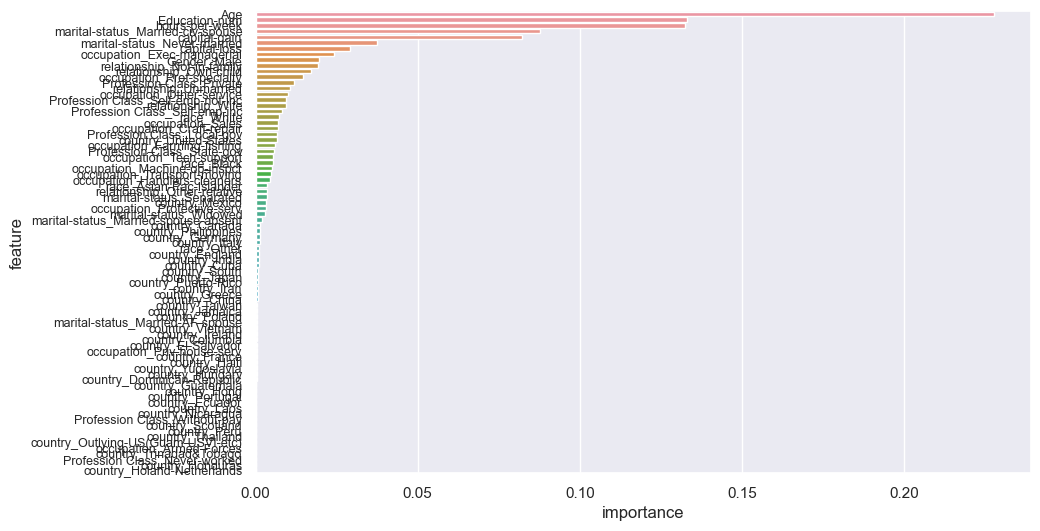

In [30]:
plt.figure(figsize=(10,6))
ax = sns.barplot(feature_rank['importance'], feature_rank['feature'])
ax.tick_params(axis = 'y',labelsize = 9)

In [49]:
# Taking cumulative sum of feature importances
feature_rank['cumsum'] = feature_rank['importance'].cumsum() * 100
feature_rank.head(29)

,feature,importance,cumsum
0,Age,0.227556,22.755563
1,Education-num,0.133018,36.057394
4,hours-per-week,0.132565,49.313938
13,marital-status_Married-civ-spouse,0.087845,58.098450
2,capital-gain,0.082243,66.322719
15,marital-status_Never-married,0.037432,70.065942
3,capital-loss,0.029203,72.986248
20,occupation_Exec-managerial,0.024248,75.411050
40,Gender_Male,0.019611,77.372100
31,relationship_Not-in-family,0.019417,79.313819


###### We can see that more than 96% of the information is gained from top 19 columns and less than 4% from bottom 10 columns. These can be dropped in later trials.

In [32]:
columns_to_be_dropped = list(feature_rank[feature_rank['cumsum'] > 96]['feature'])
columns_to_be_dropped

['relationship_Other-relative',
 'marital-status_Separated',
 'country_Mexico',
 'occupation_Protective-serv',
 'marital-status_Widowed',
 'marital-status_Married-spouse-absent',
 'country_Canada',
 'country_Philippines',
 'country_Germany',
 'country_Italy',
 'race_Other',
 'country_England',
 'country_India',
 'country_Cuba',
 'country_South',
 'country_Japan',
 'country_Puerto-Rico',
 'country_Iran',
 'country_Greece',
 'country_China',
 'country_Taiwan',
 'country_Jamaica',
 'country_Poland',
 'marital-status_Married-AF-spouse',
 'country_Vietnam',
 'country_Ireland',
 'country_Columbia',
 'country_El-Salvador',
 'occupation_Priv-house-serv',
 'country_France',
 'country_Haiti',
 'country_Yugoslavia',
 'country_Hungary',
 'country_Dominican-Republic',
 'country_Guatemala',
 'country_Hong',
 'country_Portugal',
 'country_Ecuador',
 'country_Laos',
 'country_Nicaragua',
 'Profession Class_Without-pay',
 'country_Scotland',
 'country_Peru',
 'country_Thailand',
 'country_Outlying-US(G

In [33]:
X_train.drop(columns_to_be_dropped, axis = 1, inplace = True)

In [34]:
X_test.drop(columns_to_be_dropped, axis = 1, inplace = True)

In [35]:
X_train.shape  # 11 columns dropped

(20261, 31)

## Model Building

In [36]:
# Creating instances of classification models
logisticreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
xgboost = XGBClassifier()

In [37]:
# Creating a function to predict target for testing set and to evaluate models
def predict_evaluate(ml_model):
    print('Model is:', ml_model)
    
    model = ml_model.fit(X_train, y_train)
    train_score = accuracy_score(y_train, model.predict(X_train))
    print('Accuracy score for training data:', train_score)
    
    y_pred = model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    print('Accuracy score for testing data:', test_score, end = '\n\n')
    
    print('Classification Report:', classification_report(y_test, y_pred), sep = '\n')
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred), sep = '\n')

In [40]:
predict_evaluate(logisticreg)

Model is: LogisticRegression()
Accuracy score for training data: 0.8357435467153644
Accuracy score for testing data: 0.8376324274527868

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6519
           1       0.71      0.60      0.65      2165

    accuracy                           0.84      8684
   macro avg       0.79      0.76      0.77      8684
weighted avg       0.83      0.84      0.83      8684

Confusion Matrix:
[[5979  540]
 [ 870 1295]]


In [45]:
predict_evaluate(svc)

Model is: SVC()
Accuracy score for training data: 0.8527713340901238
Accuracy score for testing data: 0.8415476738830032

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6519
           1       0.73      0.58      0.65      2165

    accuracy                           0.84      8684
   macro avg       0.80      0.75      0.77      8684
weighted avg       0.83      0.84      0.84      8684

Confusion Matrix:
[[6052  467]
 [ 909 1256]]


In [46]:
predict_evaluate(knn)

Model is: KNeighborsClassifier()
Accuracy score for training data: 0.8724149844528898
Accuracy score for testing data: 0.8164440350069092

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6519
           1       0.64      0.59      0.61      2165

    accuracy                           0.82      8684
   macro avg       0.76      0.74      0.75      8684
weighted avg       0.81      0.82      0.81      8684

Confusion Matrix:
[[5820  699]
 [ 895 1270]]


In [38]:
predict_evaluate(dtree)

Model is: DecisionTreeClassifier()
Accuracy score for training data: 0.9844528897882632
Accuracy score for testing data: 0.7970981114693689

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6519
           1       0.59      0.60      0.59      2165

    accuracy                           0.80      8684
   macro avg       0.73      0.73      0.73      8684
weighted avg       0.80      0.80      0.80      8684

Confusion Matrix:
[[5633  886]
 [ 876 1289]]


In [39]:
predict_evaluate(randomforest)

Model is: RandomForestClassifier()
Accuracy score for training data: 0.9844528897882632
Accuracy score for testing data: 0.8271533855366191

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      6519
           1       0.67      0.60      0.63      2165

    accuracy                           0.83      8684
   macro avg       0.77      0.75      0.76      8684
weighted avg       0.82      0.83      0.82      8684

Confusion Matrix:
[[5891  628]
 [ 873 1292]]


In [41]:
predict_evaluate(xgboost)

Model is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy score for training data: 0.8947238537090962
Accuracy score for testing data: 0.8642330723169046

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6519


###### XGBoost is the best model we can see right now but Decision Tree and Random Forest are overfitting a lot. Let's try to manually tune the hyperparameters.

### Hyperparameter Tuning

In [581]:
params = {'n_neighbors': [8, 10, 12]}
rcv = RandomizedSearchCV(knn, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'n_neighbors': 10}

In [47]:
knn_tuned = KNeighborsClassifier(n_neighbors = 10)
predict_evaluate(knn_tuned)

Model is: KNeighborsClassifier(n_neighbors=10)
Accuracy score for training data: 0.8540545876314101
Accuracy score for testing data: 0.8215108245048365

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      6519
           1       0.69      0.53      0.59      2165

    accuracy                           0.82      8684
   macro avg       0.77      0.72      0.74      8684
weighted avg       0.81      0.82      0.81      8684

Confusion Matrix:
[[5996  523]
 [1027 1138]]


###### We were able to increase the testing accuracy by more than 1%  and also reduce overfitting by decreasing the training accuracy.

In [583]:
params = {'max_depth': [9, 10],
          'max_leaf_nodes': [75, 100, 125]}
rcv = RandomizedSearchCV(dtree, params, random_state = 11)
rcv.fit(X_train, y_train)
rcv.best_params_

{'max_leaf_nodes': 125, 'max_depth': 10}

In [42]:
dtree_tuned = DecisionTreeClassifier(max_leaf_nodes = 75, max_depth = 10, random_state = 42)
predict_evaluate(dtree_tuned)

Model is: DecisionTreeClassifier(max_depth=10, max_leaf_nodes=75, random_state=42)
Accuracy score for training data: 0.8618528206899956
Accuracy score for testing data: 0.8478811607554122

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6519
           1       0.75      0.58      0.65      2165

    accuracy                           0.85      8684
   macro avg       0.81      0.76      0.78      8684
weighted avg       0.84      0.85      0.84      8684

Confusion Matrix:
[[6110  409]
 [ 912 1253]]


###### We can see that Decision Tree model which was hugely overfitting previously with over 96.5% training accuracy and only 79% testing accuracy has become a better fit model with 85% training accuracy and 84.7% testing accuracy, after hyperparameter tuning.

In [585]:
params = {'max_depth': [8, 10, 12],
          'max_leaf_nodes': [100, 175, 150],
          'n_estimators': [100, 175, 150]}
rcv = RandomizedSearchCV(randomforest, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'n_estimators': 100, 'max_leaf_nodes': 175, 'max_depth': 12}

In [43]:
randomforest_tuned = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = 150, max_depth = 12, random_state = 42)
predict_evaluate(randomforest_tuned)

Model is: RandomForestClassifier(max_depth=12, max_leaf_nodes=150, random_state=42)
Accuracy score for training data: 0.8649128868269088
Accuracy score for testing data: 0.8537540304007369

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6519
           1       0.79      0.57      0.66      2165

    accuracy                           0.85      8684
   macro avg       0.83      0.76      0.78      8684
weighted avg       0.85      0.85      0.85      8684

Confusion Matrix:
[[6185  334]
 [ 936 1229]]


###### We can see that Random Forest model which was hugely overfitting previously with over 96.5% training accuracy and only 82% testing accuracy has become a better fit model with 85.8% training accuracy and 84.7% testing accuracy, after hyperparameter tuning.

In [587]:
params = {'max_depth': [2, 4, 6],
          'max_leaves': [40, 50, 60],
          'n_estimators': [50, 60, 70]}
rcv = RandomizedSearchCV(xgboost, params, random_state = 42)
rcv.fit(X_train, y_train)
rcv.best_params_

{'n_estimators': 60, 'max_leaves': 50, 'max_depth': 4}

In [44]:
xgboost_tuned = XGBClassifier(n_estimators = 60, max_leaves = 50, max_depth = 4, random_state = 42)
predict_evaluate(xgboost_tuned)

Model is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=50,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Accuracy score for training data: 0.8755737624006712
Accuracy score for testing data: 0.8641179180101336

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6519
        

###### We were able to reduce overfitting in the XGBoost model without reducing the testing accuracy.

###### Modelling is complete and XGBoost gives us the best accuracy along with f1 score. Hence, XGBoost is chosen as the final model.